# CIRCUITO RC

$Z_{tot} = R + \frac{1}{j\omega C}$

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RC.csv'
fr = pd.read_csv(FILE)

In [37]:
Vin = np.array(fr['Vin']) # V
VC = np.array(fr['VC']) # V
VR = np.array(fr['VR']) # V
ν = np.array(fr['Freq (Hz)']) # Hz 
ω = 2*np.pi*ν
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦC = np.array(fr['faseC (deg)'], dtype=np.float64) * (np.pi / 180) # rad

sigma_Vin = 0.04
sigma_VR = np.array(fr['sigmaV_R'])
sigma_VC = np.array(fr['sigmaV_C'])

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) # rad
sigma_ΦC = np.array(fr['sigmaF_C'], dtype=np.float64) * (np.pi/180.0) # rad

### FUNZIONE DI TRASFERIMENTO $H_R(\omega)$:

- $|H_R(\omega)| = \frac{\omega RC}{\sqrt{1+\omega^2R^2C^2}}$
- $\angle H_R(\omega) = \frac{\pi}{2}-arctan(\omega RC)$

In [5]:
# R = 9950 # ohm
# sigmaR = R * 0.01 # errore associato ohmmetro

def mod_HR_f(ω, C): # R conosciuto
    num = ω * R * C
    den2 = 1 + (ω**2) * (R**2) * (C**2)
    return num/np.sqrt(den2)

def arg_HR_f(ω,C):
    return np.pi/2-np.arctan(ω*R*C)

In [18]:
modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + ((1/(Vin))*sigma_VR)**2)

In [38]:
C_guess = 9.55608114e-09 # usa la resistenza fissata
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[C_guess])
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[C_guess])

print("---------------------------MODULO R -------------------------")
print(fit_mod_HR)
print("---------------------------FASE R -------------------------")
print(fit_arg_HR)

---------------------------MODULO R -------------------------
   
Parameters: [-7.89184792e-12] 
Sigma parameters: [1.6895036e-09]

sigmaY: [0.01565549 0.01573192 0.01604842 0.01700637 0.01928919 0.02156073
 0.02244501 0.0228099  0.01611722 0.01636153 0.01636153]

chiquadro ridotto: 1042.35
df: 10
pvalue: 0.0%
covariance matrix: [[2.3590268e-18]]    

---------------------------FASE R -------------------------
   
Parameters: [-5.26518271e-07] 
Sigma parameters: [2.00785657e-06]

sigmaY: [0.06981317 0.03490659 0.01745329 0.01745329 0.01745329 0.01745329
 0.03490659 0.03490659 0.03490659 0.05235988 0.05235988]

chiquadro ridotto: 1308.1
df: 10
pvalue: 0.0%
covariance matrix: [[3.33180827e-12]]    



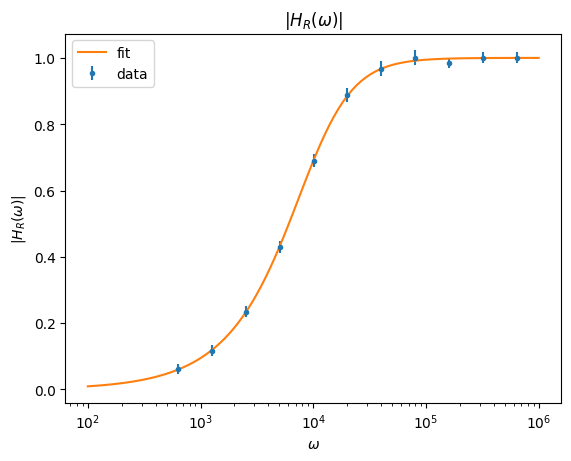

In [33]:
x = np.logspace(2,6,100)
y = mod_HR_f(x,*fit_mod_HR.bval)

plt.title('$|H_R(\omega)|$')
plt.errorbar(ω,modHR,yerr=fit_mod_HR.sigmaY,fmt='.',label='data')
plt.plot(x,y,label='fit')
plt.xlabel('$\omega$')
plt.ylabel('$|H_R(\omega)|$')
plt.xscale('log')
plt.legend()
plt.show()

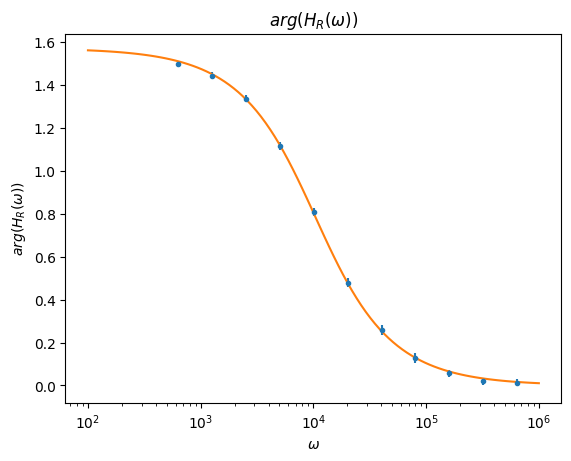

In [28]:

x = np.logspace(2,6,100)
y = arg_HR_f(x,*fit_arg_HR.bval)

plt.title('$arg(H_R(\omega))$')
plt.errorbar(ω,ΦR,yerr=fit_mod_HR.sigmaY,fmt='.')
plt.ylabel('$arg(H_R(\omega))$')
plt.xlabel('$\omega$')
plt.plot(x,y)
plt.xscale('log')
plt.show()

### FUNZIONE DI TRASFERIMENTO $H_C(\omega)$:

- $|H_C(\omega)| = \frac{1}{\sqrt{1+\omega^2R^2C^2}}$
- $\angle H_C(\omega) = -arctan(\omega RC)$


In [35]:
# R = 9950 # ohm
# sigmaR = R * 0.01 # errore associato ohmmetro

def mod_HC_f(ω, C): # R conosciuto
    num = 1
    den2 = 1 + (ω**2) * (R**2) * (C**2)
    return num/np.sqrt(den2)

def arg_HC_f(ω,C):
    return -np.arctan(ω*R*C)

In [36]:
modHC = VC/Vin
sigma_modHC = np.sqrt(((VC/(Vin**2))*sigma_Vin)**2 + ((1/(Vin))*sigma_VC)**2)

In [39]:
C_guess = 9.55608114e-09 # usa la resistenza fissata
fit_mod_HC = Interpolazione(ω,modHC,mod_HC_f,sigma_modHC,p0=[C_guess])
fit_arg_HC = Interpolazione(ω,ΦC,arg_HC_f,sigma_ΦC,p0=[C_guess])

print("---------------------------MODULO C-------------------------")
print(fit_mod_HC)
print("---------------------------FASE C-------------------------")
print(fit_arg_HC)

---------------------------MODULO C-------------------------
   
Parameters: [9.62292038e-09] 
Sigma parameters: [1.32850446e-10]

sigmaY: [0.03493856 0.03483006 0.03472294 0.03420845 0.03370991 0.01780621
 0.01665745 0.01626275 0.01590498 0.01588101 0.01588101]

chiquadro ridotto: 0.15
df: 10
pvalue: 100.0%
covariance matrix: [[1.45861495e-20]]    

---------------------------FASE C-------------------------
   
Parameters: [9.36721369e-09] 
Sigma parameters: [2.40813095e-10]

sigmaY: [0.01745329 0.01745329 0.01745329 0.01745329 0.03490659 0.05235988
 0.05235988 0.10471976 0.10471976 0.17453293 0.17453293]

chiquadro ridotto: 0.28
df: 10
pvalue: 100.0%
covariance matrix: [[4.79264024e-20]]    



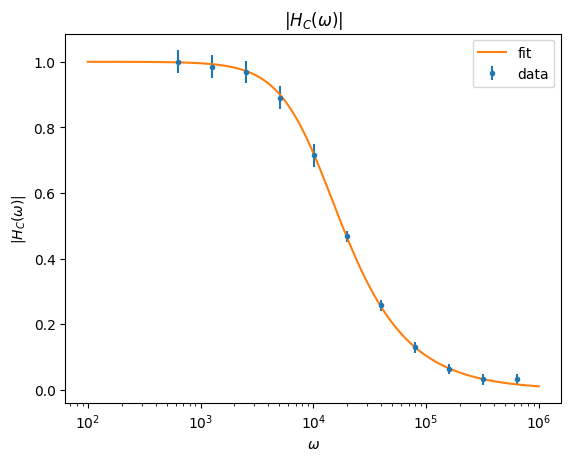

In [40]:
x = np.logspace(2,6,100)
y = mod_HC_f(x,*fit_mod_HC.bval)

plt.title('$|H_C(\omega)|$')
plt.errorbar(ω,modHC,yerr=fit_mod_HC.sigmaY,fmt='.',label='data')
plt.plot(x,y,label='fit')
plt.xlabel('$\omega$')
plt.ylabel('$|H_C(\omega)|$')
plt.xscale('log')
plt.legend()
plt.show()

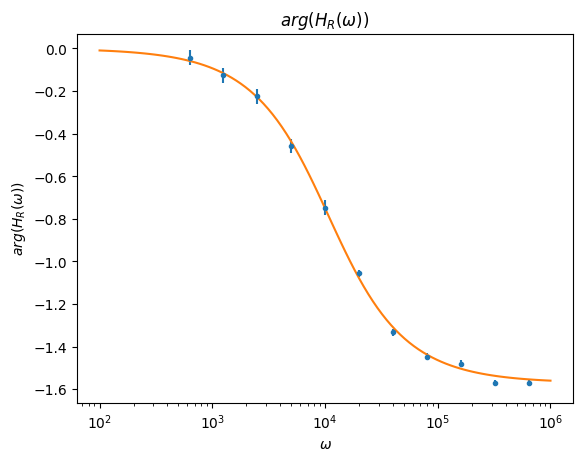

In [41]:
x = np.logspace(2,6,100)
y = arg_HC_f(x,*fit_arg_HC.bval)

plt.title('$arg(H_R(\omega))$')
plt.errorbar(ω,ΦC,yerr=fit_mod_HC.sigmaY,fmt='.')
plt.ylabel('$arg(H_R(\omega))$')
plt.xlabel('$\omega$')
plt.plot(x,y)
plt.xscale('log')
plt.show()